In [1]:
import numpy as np
import cv2
import dlib
from scipy.sparse import linalg 
import scipy
from imutils import face_utils
from matplotlib import pyplot as plt

In [2]:


def shape_to_np(shape, dtype="int"):
	
	t = np.zeros((68, 2), dtype=dtype)

	for i in range(0, 68):
		t[i] = (shape.part(i).x, shape.part(i).y)
	return t
def rect_to_bb(r):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = r.left()
	y = r.top()
	w = r.right() - x
	h = r.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

class FCS:
    def __init__(self,feature_points,image):
       
        cv2.namedWindow('Select_Forehead_Points')
        cv2.setMouseCallback('Select_Forehead_Points', self.select_point)
        self.points = np.zeros((78, 2), dtype="int")
        self.count = 0
        self.inputFeature = len(feature_points)
        self.out = np.copy(image)
        for i in range(len(feature_points)):
            self.points[i] = feature_points[i]
        for (x, y) in feature_points:
            cv2.circle(self.out, (x, y), 2, (0, 0, 255), -1)
        while self.count != 10:
            cv2.imshow("Select_Forehead_Points", self.out)
            cv2.waitKey(20)
        cv2.imshow("Select_Forehead_Points", self.out)
        cv2.waitKey(20)
        cv2.destroyWindow("Select_Forehead_Points")

    def out(self):
        return self.out

    def select_point(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            
            cv2.circle(self.out, (x, y), 2, (0, 0, 255), -1)
            self.points[self.inputFeature + self.count] = np.array([x, y], dtype="int")
            self.count = self.count + 1
        if self.count == 10:
            print("Forehead Control Point Detection Done")
            


In [3]:
def img_preprocessing(image):
    img= cv2.imread(image)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    g_i= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(g_i, 1)
    shape=3
    
    for (i, rect) in enumerate(rects):
     
        shape = predictor(g_i, rect)
        shape = face_utils.shape_to_np(shape)

        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        for (x, y) in shape:
            cv2.circle(img, (x, y), 1, (0, 0, 255), -1)

#     cv2.imshow("Output", img)
#     cv2.waitKey(0)
    print("Image with Control Points")
    plt.imshow(img[:,:,::-1])
    plt.show()

    FC = FCS(shape, img)

    output_marked_image = FC.out
    feature_points = FC.points
    img=cv2.imread(image)
    size = img.shape
    #Points need to be added as tuples in Subdiv2D
    fp=[((int(a[0])),int(a[1])) for a in feature_points]
    min_x=min(fp, key = lambda x : x[0])[0]
    min_y=min(fp, key = lambda x : x[1])[1]
    max_x=max(fp, key = lambda x : x[0])[0]
    max_y=max(fp, key = lambda x : x[1])[1]
    rectan = (min_x,min_y,   max_x,max_y)
    subdiv  = cv2.Subdiv2D(rectan)
    subdiv.insert(fp)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        cv2.line(img, pt1, pt2, (0, 255, 255), 1)
        cv2.line(img, pt2, pt3, (0, 255, 255), 1)
        cv2.line(img, pt1, pt3, (0, 255, 255), 1)
#     cv2.imshow("Output", img)
#     cv2.waitKey(0)
#     print("Subject Image after Delaunay Triangulation")
#     plt.imshow(img[:,:,::-1])
#     plt.show() 
    region_locator = np.zeros((img.shape[0], img.shape[1]))
    beta=np.zeros((img.shape[0], img.shape[1]))
    cv2.ellipse(beta,(int((min_x+max_x)/2),int((min_y+max_y)/2)),(int((max_x-min_x)/2),int((max_y-min_y)/2)),0,0,360,1,-1)
    cv2.ellipse(region_locator,(int((min_x+max_x)/2),int((min_y+max_y)/2)),(int((max_x-min_x)/2),int((max_y-min_y)/2)),0,0,360,255,-1)
    cv2.rectangle(region_locator,(min_x, min_y),(max_x,max_y), 0, 1)
    leye_fp = fp[36: 42]
    reye_fp = fp[42: 48]
    lip_fp = fp[48: 68]
    mouth_fp=fp[60:68]
    leyeb_fp=fp[17:22]
    reyeb_fp=fp[22:27]
    
    min_xleye=min(leye_fp, key = lambda x : x[0])[0]
    min_yleye=min(leye_fp, key = lambda x : x[1])[1]
    max_xleye=max(leye_fp, key = lambda x : x[0])[0]
    max_yleye=max(leye_fp, key = lambda x : x[1])[1]

    min_xreye=min(reye_fp, key = lambda x : x[0])[0]
    min_yreye=min(reye_fp, key = lambda x : x[1])[1]
    max_xreye=max(reye_fp, key = lambda x : x[0])[0]
    max_yreye=max(reye_fp, key = lambda x : x[1])[1]
    
    min_xleyeb=min(leyeb_fp, key = lambda x : x[0])[0]
    min_yleyeb=min(leyeb_fp, key = lambda x : x[1])[1]
    max_xleyeb=max(leyeb_fp, key = lambda x : x[0])[0]
    max_yleyeb=max(leyeb_fp, key = lambda x : x[1])[1]

    min_xreyeb=min(reyeb_fp, key = lambda x : x[0])[0]
    min_yreyeb=min(reyeb_fp, key = lambda x : x[1])[1]
    max_xreyeb=max(reyeb_fp, key = lambda x : x[0])[0]
    max_yreyeb=max(reyeb_fp, key = lambda x : x[1])[1]

    min_xlip=min(lip_fp, key = lambda x : x[0])[0]
    min_ylip=min(lip_fp, key = lambda x : x[1])[1]
    max_xlip=max(lip_fp, key = lambda x : x[0])[0]
    max_ylip=max(lip_fp, key = lambda x : x[1])[1]
    
    min_xmouth=min(mouth_fp, key = lambda x : x[0])[0]
    min_ymouth=min(mouth_fp, key = lambda x : x[1])[1]
    max_xmouth=max(mouth_fp, key = lambda x : x[0])[0]
    max_ymouth=max(mouth_fp, key = lambda x : x[1])[1]
    
    cv2.ellipse(region_locator,(int((min_xleye+max_xleye)/2),int((min_yleye+max_yleye)/2)),(int((max_xleye-min_xleye)/2),int((max_yleye-min_yleye)/2)),0,0,360,100,-1)
    cv2.ellipse(region_locator,(int((min_xreye+max_xreye)/2),int((min_yreye+max_yreye)/2)),(int((max_xreye-min_xreye)/2),int((max_yreye-min_yreye)/2)),0,0,360,100,-1)    
    cv2.ellipse(region_locator,(int((min_xlip+max_xlip)/2),int((min_ylip+max_ylip)/2)),(int((max_xlip-min_xlip)/2),int((max_ylip-min_ylip)/2)),0,0,360,150,-1)
    cv2.rectangle(region_locator,(min_xleye, min_yleye),(max_xleye,max_yleye), 0, 1)
    cv2.rectangle(region_locator,(min_xreye, min_yreye),(max_xreye,max_yreye), 0, 1)
    cv2.rectangle(region_locator,(min_xlip, min_ylip),(max_xlip,max_ylip), 0, 1)
    cv2.ellipse(region_locator,(int((min_xmouth+max_xmouth)/2),int((min_ymouth+max_ymouth)/2)),(int((max_xmouth-min_xmouth)/2),int((max_ymouth-min_ymouth)/2)),0,0,360,100,-1)
    cv2.rectangle(region_locator,(min_xmouth, min_ymouth),(max_xmouth,max_ymouth), 0, 1)
    
    

    cv2.ellipse(beta,(int((min_xleyeb+max_xleyeb)/2),int((min_yleyeb+max_yleyeb)/2)),(int((max_xleyeb-min_xleyeb)/2),int((max_yleyeb-min_yleyeb)/2)),0,0,360,0.3,-1)
    cv2.ellipse(beta,(int((min_xreyeb+max_xreyeb)/2),int((min_yreyeb+max_yreyeb)/2)),(int((max_xreyeb-min_xreyeb)/2),int((max_yreyeb-min_yreyeb)/2)),0,0,360,0.3,-1)
    
    
    
#     cv2.imshow('i',region_locator/255.)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    print("Masking different regions for transfer")
    plt.imshow(region_locator,cmap='gray',vmax=255,vmin=0)
    plt.show()

    #cv2.rectangle(img, (min_x, min_y),(max_x,max_y), (0,255,0), -1)
#     cv2.imshow('i',img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    print("Image After Delaunay Triangulation")
    plt.imshow(img[:,:,::-1])
    plt.show()
    return image,region_locator,img,fp,subdiv,beta


 

In [4]:
def area(a,b,c):
    return abs((a[0]*(b[1]-c[1])+b[0]*(c[1]-a[1])+c[0]*(a[1]-b[1]))/2.0)
def warping(pp_s,pp_m,deltas,deltam):
    s,rl_s,_,fps,del_s,_=pp_s   #image,region_locator,output_img,fp,subdiv,beta
    m,rl_m,_,fpm,del_m,_=pp_m
    s=cv2.imread(s)
    m=cv2.imread(m)
    warped=np.ones(s.shape)
    for tri in del_s.getTriangleList():
        s_v1=int(tri[0]),int(tri[1])
        s_v2=int(tri[2]),int(tri[3])
        s_v3=int(tri[4]),int(tri[5])
        #	cv.Subdiv2D.locate(	pt	) ->	retval, edge, vertex  -> locate(s_v1)[2] gives the vertex
        #   we do -4 because first 4 points in subdiv are of the bigger rectangle as added in the img_preprocessing func
        #   we get the corresponding point in feature points of makeup image by using the same index
        #   
        #print(del_s.locate(s_v1))
        m_v1=np.array(fpm[del_s.locate(s_v1)[2]-4])
        m_v2=np.array(fpm[del_s.locate(s_v2)[2]-4])
        m_v3=np.array(fpm[del_s.locate(s_v3)[2]-4])
        A=area(s_v1,s_v2,s_v3)
        mx = min(s_v1[0],s_v2[0],s_v3[0])
        my = min(s_v1[1], s_v2[1], s_v3[1])
        Mx = max(s_v1[0], s_v2[0], s_v3[0])
        My = max(s_v1[1], s_v2[1], s_v3[1])
        #The rectangle of these points contains all the points in the triangle and more
        #print(tri)
        warped[s_v1[1],s_v1[0]]=deltas*s[s_v1[1],s_v1[0]]+deltam*m[m_v1[1],m_v1[0]]
        warped[s_v2[1],s_v2[0]]=deltas*s[s_v2[1],s_v2[0]]+deltam*m[m_v2[1],m_v2[0]]
        warped[s_v3[1],s_v3[0]]=deltas*s[s_v3[1],s_v3[0]]+deltam*m[m_v3[1],m_v3[0]]
        for r in range(my,My+1):
            for c in range(mx,Mx+1):
                v=(c,r)
                A1=area(s_v3,s_v2,v)
                A2=area(s_v1,s_v3,v)
                A3=area(s_v1,s_v2,v)
                # this if condition checks if the point v is inside triangle by adding up areas and comparing to big triangle
                if(abs(A-(A3+A2+A1))<0.05):
                    bc1,bc2,bc3=A1/A,A2/A,A3/A
                    # Finding vhat usning barycentric coordinates found using smaller triangle areas
                    v_hat=(bc1*m_v1+bc2*m_v2+bc3*m_v3).astype(np.int64)
                    warped[r,c]=deltas*s[v[1],v[0]]+deltam*m[v_hat[1],v_hat[0]]
    return warped             

   

Subject Image on which make up is to be transferred


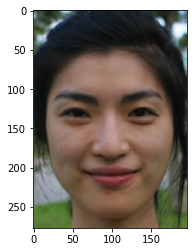

Reference Makeup Image


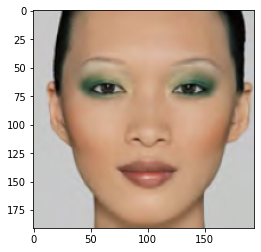

In [5]:
a=cv2.imread('i.png')
# cv2.imshow('w',a)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  
print("Subject Image on which make up is to be transferred")
plt.imshow(a[:,:,::-1])
plt.show()
a=cv2.imread('e.png')
print("Reference Makeup Image")
plt.imshow(a[:,:,::-1])
plt.show()
# cv2.imshow('w',a/255.)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  

Preprocessing Subject Image
Image with Control Points


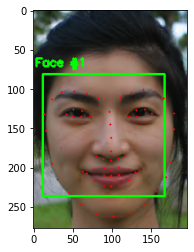

Forehead Control Point Detection Done
Masking different regions for transfer


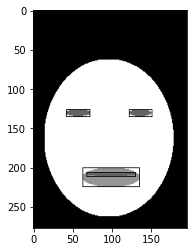

Image After Delaunay Triangulation


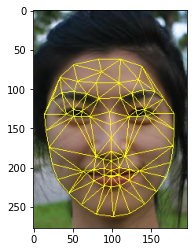

In [6]:
print("Preprocessing Subject Image")
pp_s=img_preprocessing('i.png')

Preprocessing Makeup Image
Image with Control Points


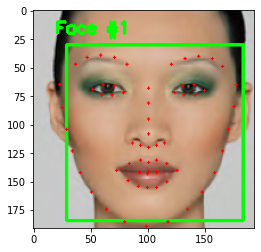

Forehead Control Point Detection Done
Masking different regions for transfer


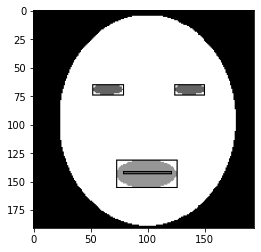

Image After Delaunay Triangulation


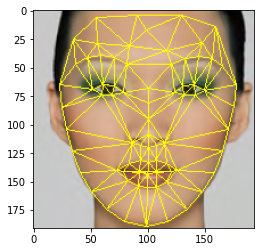

In [7]:
print("Preprocessing Makeup Image")
pp_m=img_preprocessing('e.png')


Reference Image after Warping to the shape of subject image


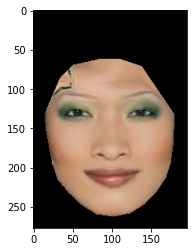

Subject Image


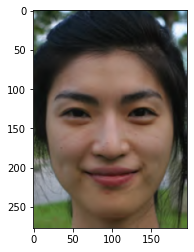

Original Reference Image


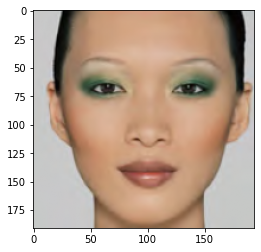

In [8]:
m=warping(pp_s,pp_m,0,1)
# cv2.imshow('w',a/255.)
# cv2.waitKey(0)
# cv2.destroyAllWindows() 
print("Reference Image after Warping to the shape of subject image")
plt.imshow(m[:,:,::-1]/255)
plt.show()
s=cv2.imread('i.png').astype(np.float32)
print("Subject Image")
plt.imshow(s[:,:,::-1]/255)
plt.show()
print("Original Reference Image")
plt.imshow(cv2.imread('e.png')[:,:,::-1]/255)
plt.show()
m=m.astype(np.float32)

In [9]:
def Skindetail_and_colour_transfer(s,m):

    lab_s=cv2.cvtColor(s/255.,cv2.COLOR_BGR2LAB).astype(np.float32)
    lab_m=cv2.cvtColor(m/255.,cv2.COLOR_BGR2LAB).astype(np.float32)
    l_s=lab_s[:,:,0]
    l_m=lab_m[:,:,0]
    c_s=lab_s[:,:,1:]
    c_m=lab_m[:,:,1:]
    s_facestruc=cv2.bilateralFilter(l_s,15,1,16)
    s_skindetail=l_s-s_facestruc
    m_facestruc=cv2.bilateralFilter(l_m,15,1,16)
    m_skindetail=l_m-m_facestruc

    final_skindetail=1*m_skindetail+0*s_skindetail
    region_locator=pp_s[1]
    c_final=np.copy(c_s)
    for r in range(c_s.shape[1]):
        for c in range(c_s.shape[0]):
            if(region_locator[c,r]==255):
                c_final[c,r]=0.8*c_m[c,r]+0.2*c_s[c,r]
            
    im=np.zeros((s.shape[0],s.shape[1],3))
    im[:,:,0]=s_facestruc+final_skindetail
    im[:,:,1:]=c_final
    im=cv2.cvtColor(im.astype(np.float32),cv2.COLOR_LAB2BGR)
    return im


Subject Image with Makeup


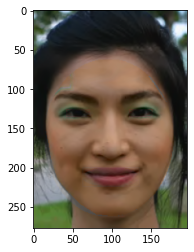

In [10]:
im=Skindetail_and_colour_transfer(s,m)
print("Subject Image with Makeup")
plt.imshow(im[:,:,::-1])
plt.show()

Stylized Image after XDoG processing


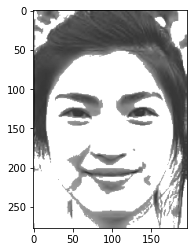

Stylized Image after XDoG processing with colour


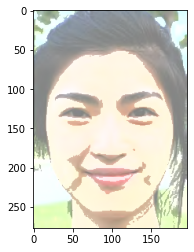

In [11]:
def Xdog_gray(img,sig,tau,k):
    img=cv2.GaussianBlur(img,(3,3),sig)-tau*cv2.GaussianBlur(img,(3,3),sig*k)
    img/=255
    return np.where(img>0.056,1, 1+np.tanh(5*(img-0.1)))

#final=cv2.imread('final_transfer.png')

#s=final
lab_s=cv2.cvtColor(s.astype(np.float32)/255.,cv2.COLOR_BGR2LAB).astype(np.float32)
#lab_m=cv2.cvtColor(m.astype(np.float32)/255.,cv2.COLOR_BGR2LAB).astype(np.float32)
l_s=lab_s[:,:,0]
#l_m=lab_m[:,:,0]
c_s=lab_s[:,:,1:]
#c_m=lab_m[:,:,1:]
xl=Xdog_gray(l_s,0.5,0.6,200)*100
print("Stylized Image after XDoG processing")
plt.imshow(xl,cmap='gray')
plt.show()

im[:,:,0]=xl
im[:,:,1:]=c_s
im=cv2.cvtColor(im.astype(np.float32),cv2.COLOR_LAB2BGR)
# cv2.imshow('3',im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  
print("Stylized Image after XDoG processing with colour")
plt.imshow(im[:,:,::-1])
plt.show()

# cv2.imwrite('xdog.png',im*255.)
# print(im*255.)



In [ ]:
# Code for Poission Editing Commented Out as it gave blurry results

In [ ]:

'''
def grad_x(img):
    a=np.copy(img)

    for r in range(img.shape[1]):
        for c in range(1,img.shape[0]): 
            img[c,r]-=a[c-1,r]
    return img        
def grad_y(img):
    a=np.copy(img)
    for r in range(1,img.shape[1]):
        for c in range(1,img.shape[0]):
             
            img[c,r]-=a[c,r-1]
            
    return img  

s_Gx = cv2.Sobel(s_facestruc,cv2.CV_8U,1,0,ksize=3)/9.
s_Gy = cv2.Sobel(s_facestruc,cv2.CV_8U,0,1,ksize=3)/9.
#s_Gx=grad_x(s_facestruc)
#s_Gy=grad_y(s_facestruc)
s_G=np.sqrt(s_Gx**2+s_Gy**2)
m_Gx = cv2.Sobel(m_facestruc,cv2.CV_64F,1,0,ksize=3)/9.
m_Gy = cv2.Sobel(m_facestruc,cv2.CV_64F,0,1,ksize=3)/9.
#m_Gx = grad_x(m_facestruc)
#m_Gy = grad_y(m_facestruc)

m_G=np.sqrt(m_Gx**2+m_Gy**2)



beta=pp_s[-1]
final_facestruc_G=np.where(abs(beta*s_G)>abs(m_G) ,s_G, m_G)
final_facestruc_Gx=cv2.Sobel(final_facestruc_G,cv2.CV_64F,1,0,ksize=3)/9
final_facestruc_Gy=cv2.Sobel(final_facestruc_G,cv2.CV_64F,0,1,ksize=3)/9
#final_facestruc_Gx=grad_x(final_facestruc_G)
#final_facestruc_Gy=grad_y(final_facestruc_G)

final_facestruc_G=final_facestruc_Gx+final_facestruc_Gy

#or directly take laplacian?
#m_G=cv2.Laplacian(src=np.float64(m_facestruc),ddepth=cv2.CV_64F,ksize=3)
#s_G=cv2.Laplacian(np.float64(s_facestruc),cv2.CV_64F,3)
#final_facestruc_G=np.where(abs(beta*s_G)>abs(m_G) ,s_G, m_G)

sparsepoints={}

d=0
indicelist=[]
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            sparsepoints[(c,r)]=d
            indicelist.append((c,r))
            d+=1
           

sparseval=[final_facestruc_G[c,r] for c,r in indicelist]            
smatrix= scipy.sparse.lil_matrix((len(sparsepoints),len(sparsepoints)))
for j in range(len(sparsepoints)):
    c,r=indicelist[j]
    p=final_facestruc_G[c,r]
    smatrix[j,j]=4
    check=0
    if ((c-1,r) in sparsepoints):
        d=sparsepoints[(c-1,r)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c+1,r) in sparsepoints):
        d=sparsepoints[(c+1,r)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c,r-1) in sparsepoints):
        d=sparsepoints[(c,r-1)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c,r+1) in sparsepoints):
        d=sparsepoints[(c,r+1)]
        smatrix[j,d]=-1
        check+=1
    if check==4 :
        sparseval[j]+=m_G[c,r]
        

        
x=linalg.cg(smatrix,sparseval)

d=0
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            final_facestruc_G[c,r]=x[0][d]
            d+=1
        
final_l=final_facestruc_G+final_skindetail

x=list(x)
x=x[0]
m=min(x)
M=max(x)
print(m,M)
print(np.mean(x))
y=[(s-m)*100/(M-m) for s in x]

d=0
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            final_facestruc_G[c,r]=y[d]
            d+=1
final_l=final_facestruc_G+final_skindetail
#cv2.imshow('3',final_l/100)
#cv2.waitKey(0)
#cv2.destroyAllWindows() 
'''

In [376]:
'''
s_Gx = cv2.Sobel(s_facestruc,cv2.CV_8U,1,0,ksize=3)/9.
s_Gy = cv2.Sobel(s_facestruc,cv2.CV_8U,0,1,ksize=3)/9.
#s_Gx=grad_x(s_facestruc)
#s_Gy=grad_y(s_facestruc)
s_G=np.sqrt(s_Gx**2+s_Gy**2)
m_Gx = cv2.Sobel(m_facestruc,cv2.CV_64F,1,0,ksize=3)/9.
m_Gy = cv2.Sobel(m_facestruc,cv2.CV_64F,0,1,ksize=3)/9.
#m_Gx = grad_x(m_facestruc)
#m_Gy = grad_y(m_facestruc)

m_G=np.sqrt(m_Gx**2+m_Gy**2)
'''

In [377]:
'''
np.min(m_G)
'''

0.0

In [378]:
'''
beta=pp_s[-1]
final_facestruc_G=np.where(abs(beta*s_G)>abs(m_G) ,s_G, m_G)
final_facestruc_Gx=cv2.Sobel(final_facestruc_G,cv2.CV_64F,1,0,ksize=3)/9
final_facestruc_Gy=cv2.Sobel(final_facestruc_G,cv2.CV_64F,0,1,ksize=3)/9
#final_facestruc_Gx=grad_x(final_facestruc_G)
#final_facestruc_Gy=grad_y(final_facestruc_G)

final_facestruc_G=final_facestruc_Gx+final_facestruc_Gy

#or directly take laplacian?
#m_G=cv2.Laplacian(src=np.float64(m_facestruc),ddepth=cv2.CV_64F,ksize=3)
#s_G=cv2.Laplacian(np.float64(s_facestruc),cv2.CV_64F,3)
#final_facestruc_G=np.where(abs(beta*s_G)>abs(m_G) ,s_G, m_G)
'''

In [380]:
'''
np.min(final_facestruc_G)
'''

-21.815854308224758

In [381]:
'''
sparsepoints={}

d=0
indicelist=[]
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            sparsepoints[(c,r)]=d
            indicelist.append((c,r))
            d+=1
           

sparseval=[final_facestruc_G[c,r] for c,r in indicelist]            
smatrix= scipy.sparse.lil_matrix((len(sparsepoints),len(sparsepoints)))
for j in range(len(sparsepoints)):
    c,r=indicelist[j]
    p=final_facestruc_G[c,r]
    smatrix[j,j]=4
    check=0
    if ((c-1,r) in sparsepoints):
        d=sparsepoints[(c-1,r)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c+1,r) in sparsepoints):
        d=sparsepoints[(c+1,r)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c,r-1) in sparsepoints):
        d=sparsepoints[(c,r-1)]
        smatrix[j,d]=-1
        check+=1
        
    if ((c,r+1) in sparsepoints):
        d=sparsepoints[(c,r+1)]
        smatrix[j,d]=-1
        check+=1
    if check==4 :
        sparseval[j]+=m_G[c,r]
        

        
x=linalg.cg(smatrix,sparseval)

d=0
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            final_facestruc_G[c,r]=x[0][d]
            d+=1
        
'''      
                                                                                               

In [382]:
'''
final_l=final_facestruc_G+final_skindetail
'''

In [383]:
'''
x[0][:100]
'''

array([ 59.44301815,  80.66017124,  89.66759783,  94.36431084,
        96.91807013,  98.13388321,  98.57820243,  98.72693916,
        98.72664596,  98.48760963,  97.90612074,  96.98914793,
        95.84016296,  94.56975548,  93.00838665,  90.96574138,
        88.55874795,  85.45000526,  80.30618814,  70.97368506,
        51.31880752,  51.70591762,  72.4436422 ,  82.80050076,
        89.35200279,  94.66235786, 100.22967858, 107.82752971,
       121.38177603, 152.83578494, 171.63552276, 182.78165583,
       190.50122222, 195.07532229, 196.98985095, 197.40262208,
       197.50835254, 197.58730605, 197.19421567, 195.93570621,
       193.88931732, 191.35731114, 188.51690271, 185.16474534,
       181.20933469, 176.75377189, 171.11276043, 162.94947101,
       151.31326124, 134.30254214, 110.82807649, 100.61526915,
        95.05163637,  91.18522999,  86.90188139,  80.42767372,
        70.33656956,  50.6932469 ,  44.79918098,  62.38400772,
        72.60049775,  82.11994816,  96.17807392, 127.00

print(3)

In [384]:
'''
x=list(x)
x=x[0]
'''

In [386]:
'''
x=list(x)
x=x[0]
m=min(x)
M=max(x)
print(m,M)
print(np.mean(x))
y=[(s-m)*100/(M-m) for s in x]
'''

11.404869468554296 3027.556111155931
1531.3127626297633


In [387]:
'''
x=list(x)
x=x[0]
m=min(x)
M=max(x)
print(m,M)
print(np.mean(x))
y=[(s-m)*100/(M-m) for s in x]

d=0
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            final_facestruc_G[c,r]=y[d]
            d+=1
'''                     

In [388]:
'''
x=list(x)
x=x[0]
m=min(x)
M=max(x)
print(m,M)
print(np.mean(x))
y=[(s-m)*100/(M-m) for s in x]

d=0
for r in range(final_facestruc_G.shape[1]):
    for c in range(final_facestruc_G.shape[0]):
        if(beta[c,r]>0):
            final_facestruc_G[c,r]=y[d]
            d+=1
final_l=final_facestruc_G+final_skindetail
#cv2.imshow('3',final_l/100)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
'''

In [389]:
'''
im=np.zeros((final_l.shape[0],final_l.shape[1],3))
'''

In [390]:
'''
im[:,:,0]=final_l
im[:,:,1:]=c_final
im=cv2.cvtColor(im.astype(np.float32),cv2.COLOR_LAB2BGR)
'''

In [391]:
'''
cv2.imshow('3',im)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

In [64]:
'''
im[:,:,0]=l_s
'''

In [280]:
'''
def grad_x(img):
    a=np.copy(img)

    for r in range(img.shape[1]):
        for c in range(1,img.shape[0]): 
            img[c,r]-=a[c-1,r]
    return img        
def grad_y(img):
    a=np.copy(img)
    for r in range(1,img.shape[1]):
        for c in range(1,img.shape[0]):
             
            img[c,r]-=a[c,r-1]
            
    return img        
'''

In [149]:
'''
def highlight_shading_transfer(masks, structureSubject, structureExample):
    shape = structureSubject.shape
    structureResult = np.ndarray(shape=shape, dtype='uint8')
    der_structureResult = np.ndarray(shape=shape, dtype='uint8')

    der_structureExample = laplacian(structureExample)
    der_structureSubject = laplacian(structureSubject)
    # gauss_structureExample = gaussian(structureExample)
    gauss_structureSubject = gaussian(structureSubject)

    beta = masks

    for i in range(shape[0]):
        for j in range(shape[1]):
            if(abs(der_structureExample[i, j])*beta[i, j] > abs(der_structureSubject[i, j])):
                der_structureResult[i, j] = structureSubject[i, j]
            else:
                der_structureResult[i, j] = structureExample[i, j]

    structureResult = der_structureResult
    
    return structureResult
'''    

In [150]:
'''
def laplacian(image):
    # kernel = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
    kernel = [[0, 0, -1, 0, 0], [0, -1, -2, -1, 0], [-1, -2, 16, -2, -1], [0, -1, -2, -1, 0], [0, 0, -1, 0, 0]]
    kernel = np.array(kernel)
    laplacian = cv2.filter2D(image,-1,kernel)
    # laplacian = cv2.Laplacian(image,cv2.CV_64F)
    return laplacian

def gaussian(image):
    # lap = laplacian(image)
    gaussian = cv2.GaussianBlur(image,(5,5),0)
    return gaussian
'''    

In [151]:
'''
final_facestruc=highlight_shading_transfer(beta,s_facestruc,m_facestruc)
'''

In [152]:
'''
final_l=final_facestruc+final_skindetail
'''

In [155]:
'''
im[:,:,0]=l_s
im[:,:,1:]=c_final
'''

In [156]:
'''
im=np.zeros((s.shape[0],s.shape[1],3))
im[:,:,0]=l_s
im[:,:,1:]=c_final
im=cv2.cvtColor(im.astype(np.float32),cv2.COLOR_LAB2BGR)
cv2.imshow('3',im)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

In [616]:
'''
im[:,:,0]=xl*100
im[:,:,1:]=c_s
im=cv2.cvtColor(im.astype(np.float32),cv2.COLOR_LAB2BGR)
cv2.imshow('3',xl)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''